# Oversampling Demonstration

This notebook uses an excerpt of code from `main_centralized.py` to illustrate how oversampling of the time variable, `time_step`, in the Scania data alters the distribution of this variable. This oversampling procedure is built into `data_processing.py` and happens automatically if enabled.

This notebook also outputs two unduplicated (cross-sectional) datasets based on oversampling:
- `./data/imputed_scania_undup_smote_train.csv.gz` - training dataset containing oversampling
- `./data/imputed_scania_undup_test.csv.gz` - test dataset with no oversampling

Note - it is critical to only perform oversampling on the training set, not the test set. 

Currently, these data splits are not used elsewhere, though may be in future work.

In [1]:
%%capture
# We need to alter the working directory since the scripts are written expecting that ./time_to_failure will be the working directory
%cd ..

In [2]:
import pandas as pd
import numpy as np
from ImbalancedLearningRegression import smote
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from federated.utils import set_seeds  # needed for reproducibility if using SMOTE
set_seeds(42)

plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 14})
plt.rcParams['lines.linewidth'] = 3

### Read panel dataset

In [3]:
df = pd.read_csv('./data/imputed_scania.csv.gz', compression='infer')

In [4]:
# Define key column names
time_identifier = 'time_step'
unit_identifier = 'vehicle_id'
target_feature = 'in_study_repair'
seed = 42
test_size = 0.2

### Unduplicate data, keeping last observation

In [5]:
df = df[df[time_identifier] == df.groupby(unit_identifier)[time_identifier].transform('max')]

In [6]:
df.shape

(23550, 190)

### Stratified train-test split

Stratified on target feature - observed or censored

In [7]:
x_train, x_test, _, _ = train_test_split(df[[unit_identifier]], df[target_feature], test_size=test_size,
                                        random_state=seed, stratify=df[target_feature])

### Create datasets using identifiers above

In [8]:
# Create train and test sets, also shuffle
test = df[df[unit_identifier].isin(x_test[unit_identifier].tolist())].copy()\
    .sample(frac=1.0, random_state=seed).reset_index(drop=True)
train = df[df[unit_identifier].isin(x_train[unit_identifier].tolist())].copy()\
    .sample(frac=1.0, random_state=seed).reset_index(drop=True)  # includes val observations

In [9]:
print(test.shape, train.shape)

(4710, 190) (18840, 190)


In [10]:
train.head()

,vehicle_id,time_step,in_study_repair,100_0,158_0,158_1,158_2,158_3,158_4,158_5,...,Spec_6_Cat8,Spec_6_Cat9,Spec_7_Cat1,Spec_7_Cat2,Spec_7_Cat3,Spec_7_Cat4,Spec_7_Cat5,Spec_7_Cat6,Spec_7_Cat7,Spec_7_Cat8
0,17940.0,171.0,0.0,11038433.0,8693731.0,53795634.0,76065892.0,36821584.0,24766959.0,13603013.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10584.0,236.0,0.0,25944693.0,370515.0,99356895.0,84513544.0,30808565.0,49349386.0,31837713.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,12263.0,176.0,0.0,38936362.0,467661.0,86039529.0,80902610.0,17841648.0,14588827.0,10472307.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2432.0,174.4,0.0,10902354.0,3515992.0,63249974.0,63165387.0,14965923.0,13342635.0,9991794.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6580.0,155.4,0.0,37128971.0,7012865.0,77547316.0,98610319.0,32737852.0,18173561.0,9091158.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### SMOTE

In [ ]:
# Oversample training set
R = 0.75  # threshold for relative imbalance
resampled = smote(
    data=train.copy(),
    y=time_identifier,
    k=5,
    samp_method='balance',
    drop_na_col=False,
    drop_na_row=False,
    rel_thres = R,
    rel_method = 'auto',
    rel_xtrm_type = 'high',
    rel_coef = R
)

/Users/josephking/miniconda3/envs/time-to-failure/lib/python3.11/site-packages/ImbalancedLearningRegression/phi_ctrl_pts.py:94: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  bx_plt_st = box_plot_stats(y, coef)
synth_matrix:   0%|          | 0/2439 [00:00<?, ?it/s]/Users/josephking/miniconda3/envs/time-to-failure/lib/python3.11/site-packages/ImbalancedLearningRegression/over_sampling_smote.py:231: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  neigh = int(np.random.choice(
r_index: 100%|##########| 2103/2103 [00:04<00:00, 421.39it/s]


### Postprocess

In [12]:
# Correct categorical features back to binary since SMOTE doesn't handle them well
for col in [i for i in df.columns if "Cat" in i]:  # note - "Cat" is dataset specific, remove if not applicable
    resampled[col] = np.where(resampled[col] > 0.5, 1, 0)

In [13]:
resampled.head()

,vehicle_id,time_step,in_study_repair,100_0,158_0,158_1,158_2,158_3,158_4,158_5,...,Spec_6_Cat8,Spec_6_Cat9,Spec_7_Cat1,Spec_7_Cat2,Spec_7_Cat3,Spec_7_Cat4,Spec_7_Cat5,Spec_7_Cat6,Spec_7_Cat7,Spec_7_Cat8
0,346.0,350.4,1.0,17521058.0,9419651.0,125413678.0,159192891.0,113016434.0,55804477.0,27889502.0,...,0,0,0,0,0,0,0,0,0,0
1,6048.0,350.4,0.0,48875077.0,7839552.0,127191130.0,166745549.0,79652103.0,73966198.0,41994980.0,...,0,0,0,0,0,0,0,0,0,0
2,4739.0,350.4,0.0,48835952.0,1984212.0,167229039.0,199093812.0,86836678.0,60300014.0,26441163.0,...,0,0,1,0,0,0,0,0,0,0
3,33482.0,350.4,0.0,60672011.0,5240665.0,126642571.0,212369076.0,73471867.0,42904125.0,22423084.0,...,0,0,1,0,0,0,0,0,0,0
4,33479.0,350.4,0.0,42226181.0,3622846.0,103778878.0,142906010.0,105016198.0,47790889.0,15229458.0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
resampled.shape

(25821, 190)

### Compare `time_identifier` distribution before and after SMOTE

In [15]:
# Before
train[time_identifier].describe()

count    18840.000000
mean       235.025817
std         89.300136
min         37.000000
25%        158.200000
50%        215.400000
75%        305.400000
max        507.400000
Name: time_step, dtype: float64

In [16]:
# After
resampled[time_identifier].describe()

count    25821.000000
mean       276.908343
std        103.795992
min         37.000000
25%        177.400000
50%        284.400000
75%        371.144011
max        636.600000
Name: time_step, dtype: float64

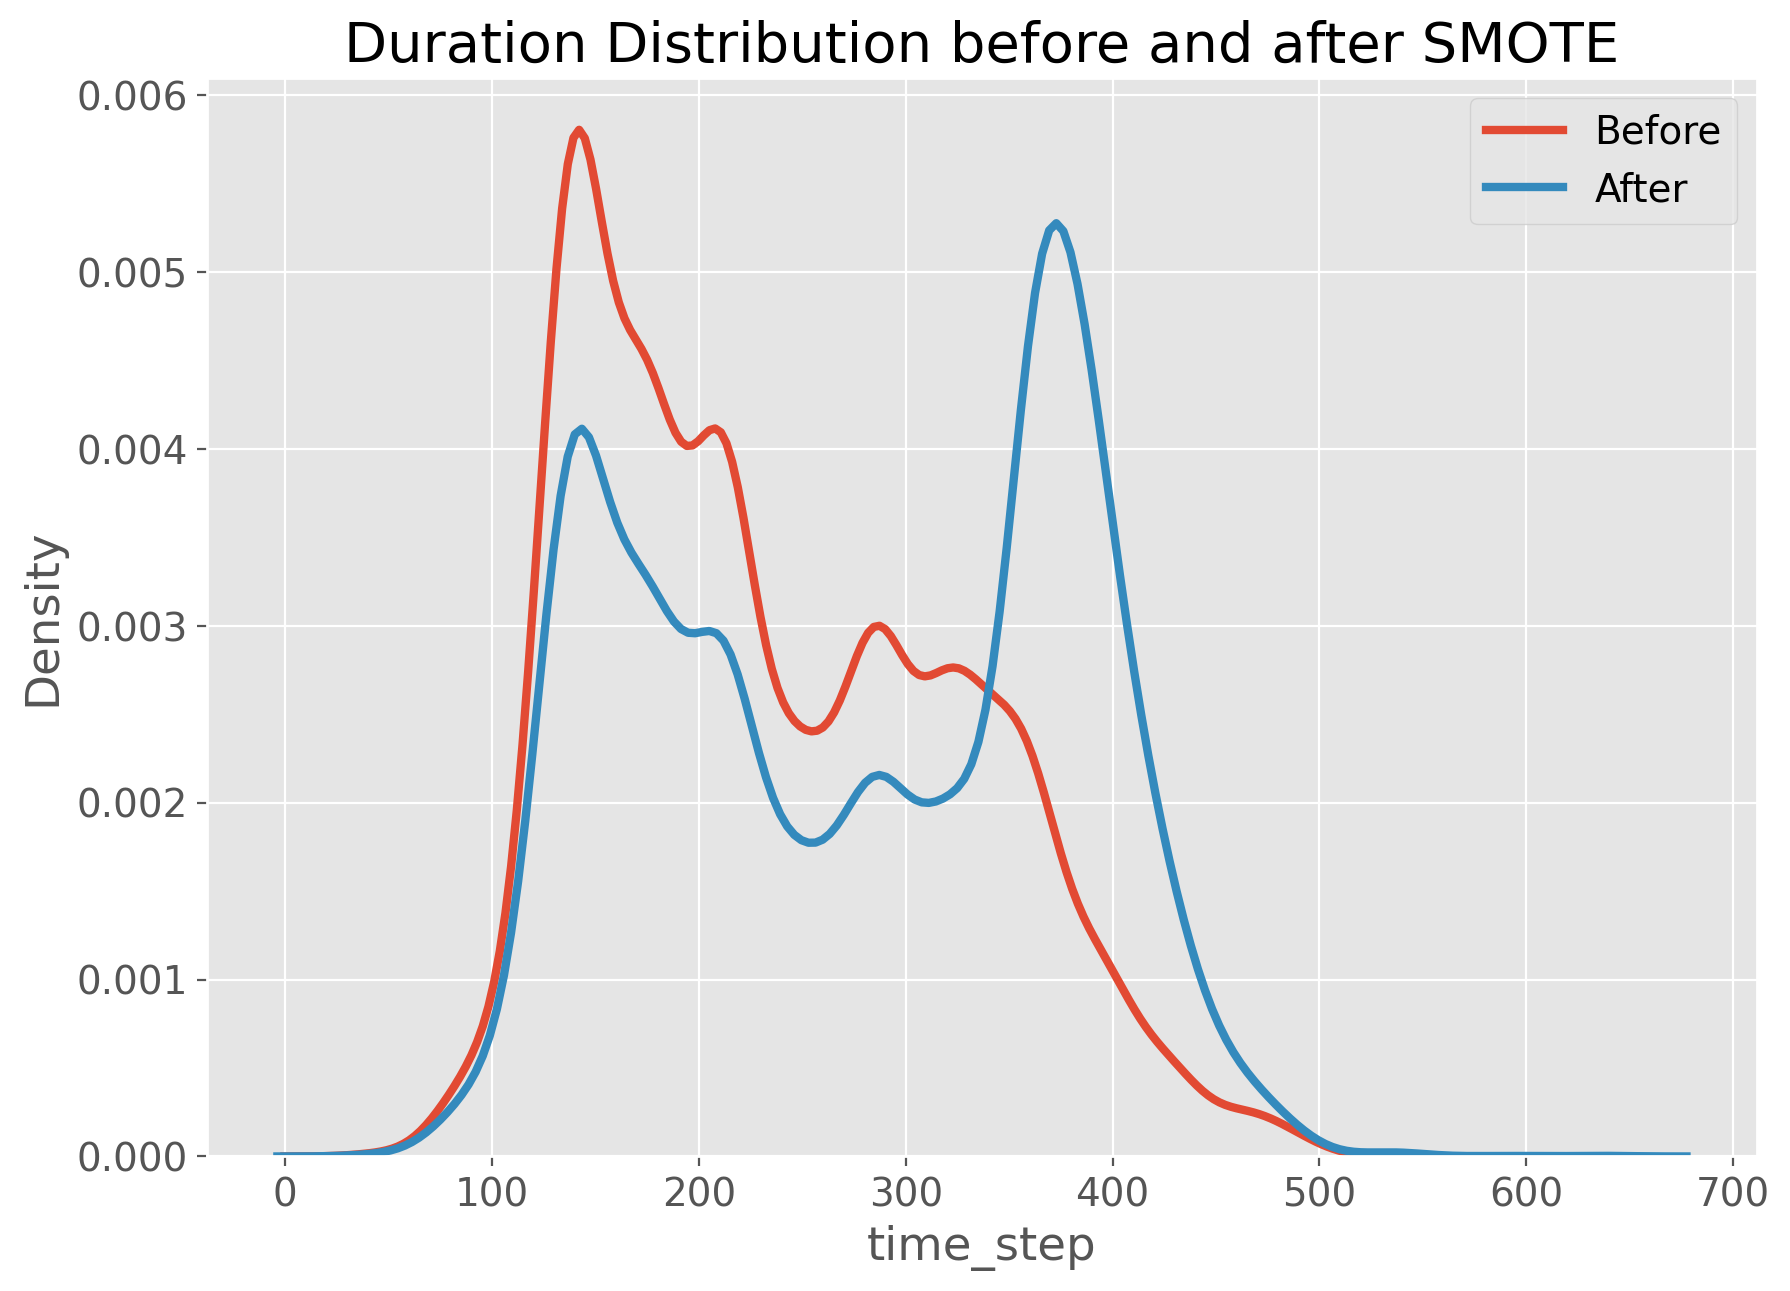

In [17]:
plt.figure(figsize=(10,7))
sns.kdeplot(train[time_identifier], label='Before')
sns.kdeplot(resampled[time_identifier], label='After')
plt.title("Duration Distribution before and after SMOTE")
plt.legend()
plt.show()

In [18]:
resampled[unit_identifier].duplicated().sum()

0

In [20]:
set(resampled[unit_identifier]).intersection(set(test[unit_identifier]))

set()

In [30]:
resampled.to_csv('./data/imputed_scania_undup_smote_train.csv.gz', compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1}, index=False)
test.to_csv('./data/imputed_scania_undup_test.csv.gz', compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1}, index=False)